Example of the process of doing DEMs for all orbits for a given observation of an AR – where we don't window out any intervals because of shifts, etc. Instead, we will save energy-specific information about the percent of NuSTAR emission in the chosen region as a function of time, for later inspection. This will help identify cases where pointing shifts might cause unphysical distortion to the DEM inputs. 

Note: auto-download of an AIA file (for use in the initial co-alignmnet) will break while the JSOC is still down. We will add a thing where you can point to an existing AIA file instead.

Overview:

- Define orbits
- Run time interval selection
- Examine resulting intervals
- Manually establish a co-alignment shift between NuSTAR and AIA
- Automatically find co-alignment shifts + make regions for all other time intervals (note: this relies on the assumption that the COM is a good representation of the location of the brightest source, i.e. that the NuSTAR data is primarially one blob).
- Save AIA region files for NCCS input
- NOT IN THIS NOTEBOOK: YOU THEN TAKE THOSE AND MAKE AIA INPUTS ON THE NCCS
- Conduct AIA/NuSTAR DEMs as a function of time, given all the above
- Plot results.
- Print some stats about "left out" times.

In [1]:
# import matplotlib.pyplot as plt
# import numpy as np
# import glob
# from astropy.io import fits
# from astropy import units as u
# import importlib
# import pathlib

#Path to top-level do-dem directory - edit for your system.
path_to_dodem = '/Users/jmdunca2/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')

# #import nustar_dem_prep as nu
import images_and_coalignment as iac
import time_interval_selection as tis
import nustar_utilities as nuutil
import gauss2D as g2d
import nustar_dem_prep as nu


# import os
# # For macOS
# def play_sound():
#     os.system("afplay /System/Library/Sounds/Glass.aiff")

import pickle
import pathlib
import importlib
from astropy import units as u
import numpy as np


In [2]:
key = '19-feb-16'

with open('all_targets.pickle', 'rb') as f:
    data = pickle.load(f)
    
method = data[key]['method']
ARDict = data[key]

id_dirs = ARDict['datapaths']
obsids = ARDict['obsids']
working_dir = ARDict['working_dir']

if method=='double':
    gauss_stats = ARDict['gauss_stats']
    sep_axis = gauss_stats[0][0]
else:
    sep_axis = ''

In [4]:
obsids=[]
for id in id_dirs:
    evt_data, hdr, obsid = nu.return_submap(datapath=id, fpm='A', return_evt_hdr=True, return_obsid=True)
    obsids.append(obsid)
    time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
    timerange = [time0, time1]
    print(timerange[0].strftime('%H-%M-%S'), timerange[1].strftime('%H-%M-%S'))
    

18-54-46 19-54-54
20-31-29 21-22-26
22-08-12 23-03-57


In [5]:
importlib.reload(iac)
aia_dir = '/Users/jmdunca2/sample_aia/sample_aia/'


aiamaps = iac.get_orbit_aiamaps(aia_dir, id_dirs, wave=94)   

/Users/jmdunca2/nustar/feb-2016/20102011001/
2016-02-19 18:54:46
['/Users/jmdunca2/sample_aia/sample_aia/aia.lev1.94A_2016-02-19T185400.12Z.image_lev1.fits']
/Users/jmdunca2/nustar/feb-2016/20102012001/
2016-02-19 20:31:29
['/Users/jmdunca2/sample_aia/sample_aia/aia.lev1.94A_2016-02-19T203100.12Z.image_lev1.fits']
/Users/jmdunca2/nustar/feb-2016/20102013001/
2016-02-19 22:08:12
['/Users/jmdunca2/sample_aia/sample_aia/aia.lev1.94A_2016-02-19T220800.14Z.image_lev1.fits']


Goal: write a combined fundtion that, for any number of regions found via any method, plots nustar contours over aia data with all regions shown. 
- In the case of multiple regions (and therefore, multiple different sets of time intervals per orbit), choose the longest time interval for the NuSTAR data.
- In the case where some of the orbits failed TIS for some regions, account for this (only plot sucessful-TIS regions). 

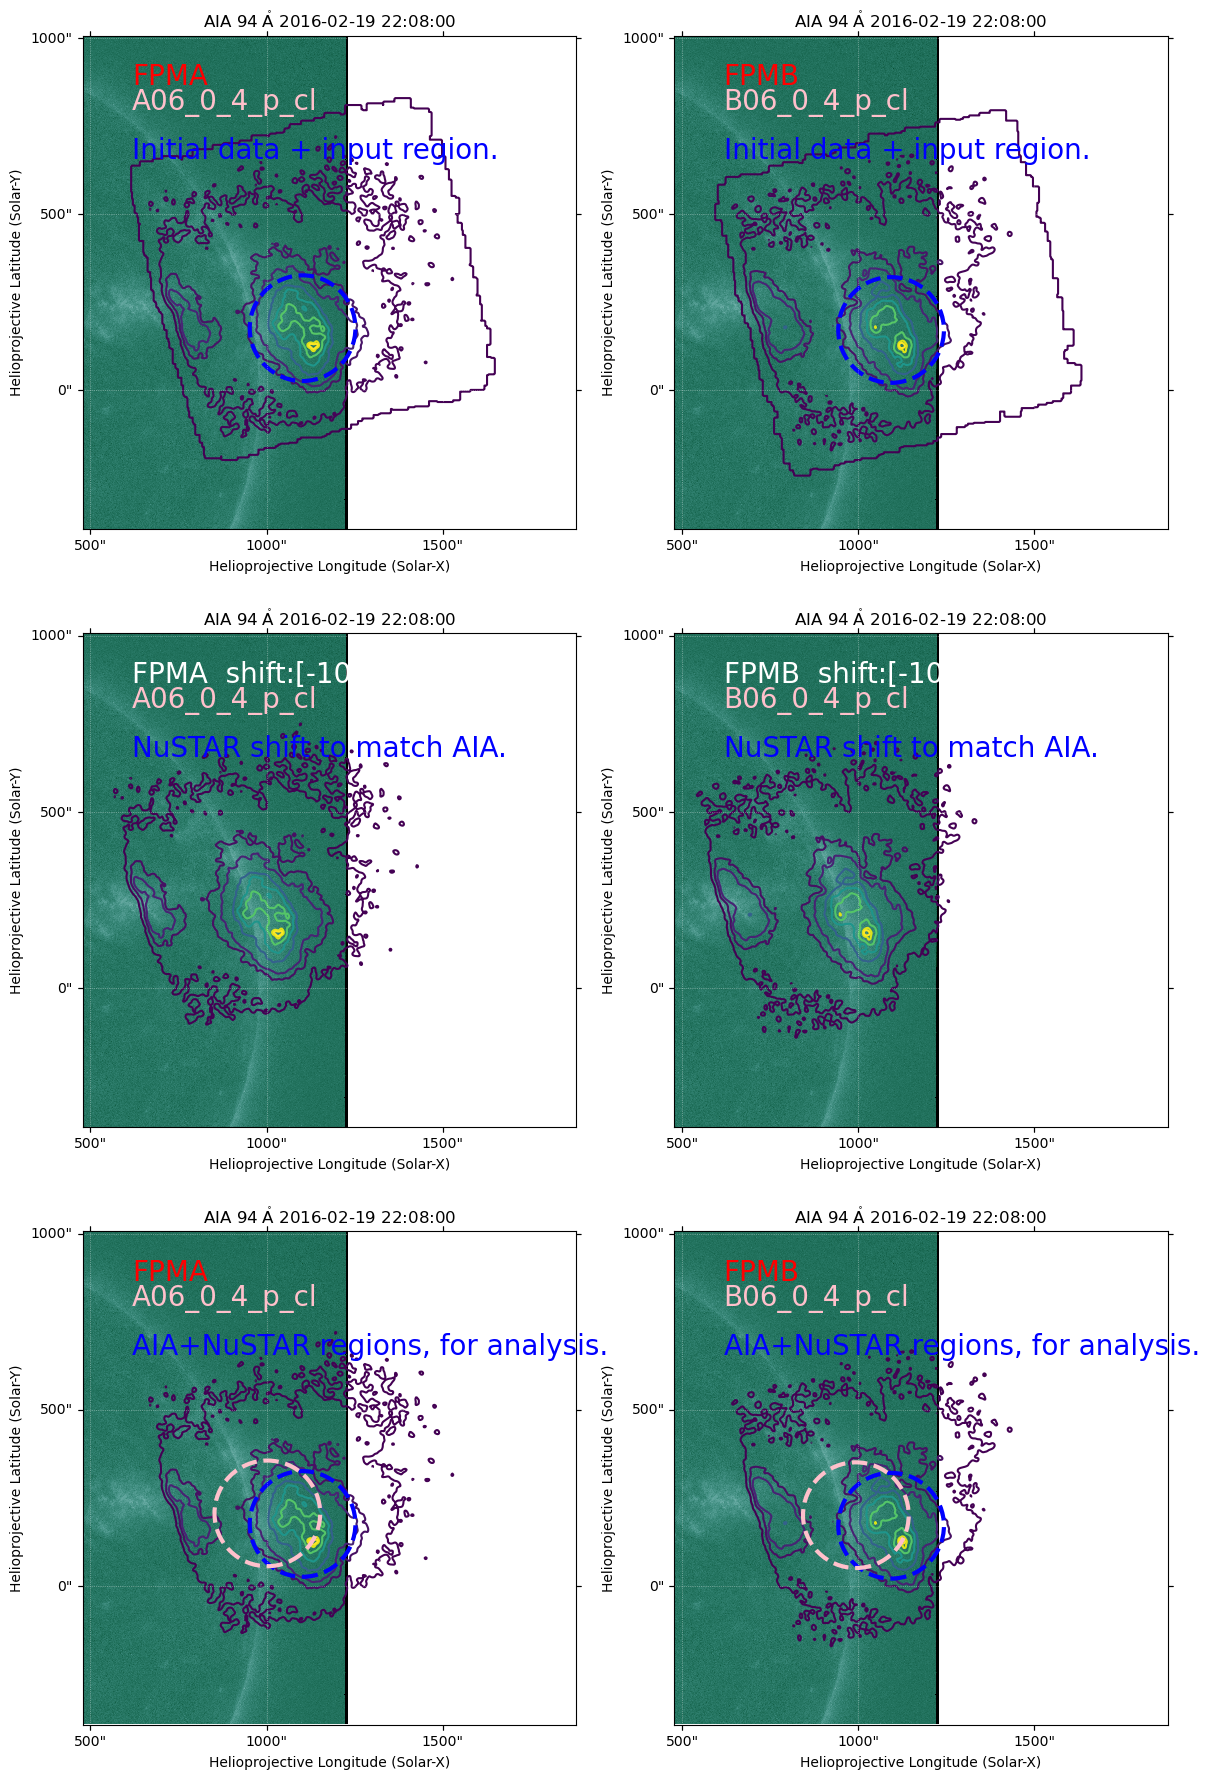

In [9]:
importlib.reload(iac)
aati = iac.per_orbit_region_adjustment(working_dir, id_dirs, obsids, 2, aiamaps, 
                                       nushift=[-100, 30], method=method, shush=True, sep_axis=sep_axis)




In [11]:
importlib.reload(iac)

if method in ['input', 'double']:
    if method=='input':
        region_dirs = iac.find_region_dirs(working_dir)
    if method=='double':
        region_dirs = iac.find_direction_dirs(working_dir, sep_axis)

    for r in region_dirs:
        all_time_intervals, all_time_intervals_list = tis.find_all_intervals(r)
        suborbit_dirs = iac.make_all_aia_dicts(all_time_intervals, r, key, additional_path=working_dir)

if method=='fit':
    all_time_intervals, all_time_intervals_list = tis.find_all_intervals(working_dir)
    suborbit_dirs = iac.make_all_aia_dicts(all_time_intervals, working_dir, key)

0 - 0 18-54-50 19-08-55
0 - 1 19-08-55 19-31-40
0 - 2 19-31-40 19-54-50

1 - 0 20-31-30 20-34-35
1 - 1 20-34-35 20-37-45
1 - 2 20-37-45 20-41-15
1 - 3 20-41-15 20-45-00
1 - 4 20-45-00 20-50-20
1 - 5 20-50-20 20-52-35
1 - 6 20-52-35 20-54-40
1 - 7 20-54-40 20-56-00
1 - 8 20-56-00 20-58-20
1 - 9 20-58-20 21-01-30
1 - 10 21-01-30 21-04-20
1 - 11 21-04-20 21-07-05
1 - 12 21-07-05 21-10-25
1 - 13 21-10-25 21-16-25
1 - 14 21-16-25 21-22-25

2 - 0 22-08-15 22-17-05
2 - 1 22-17-05 22-22-55
2 - 2 22-22-55 22-37-35
2 - 3 22-37-35 22-48-45
2 - 4 22-48-45 22-54-10
2 - 5 22-54-10 23-03-55



In [ ]:
# firl = '/Users/jmdunca2/do-dem/initial_dem_8jun20/19-54-59_20-00-54/19-54-59_20-00-54_aia_region.pickle'
firl = '/Users/jmdunca2/do-dem/initial_dem_12sep17/all_aia_dicts_12-sep-17_post/orbit_80310229001/20-59-30_21-00-00_aia_prep.pickle'
with open(firl, 'rb') as f:
    data = pickle.load(f)

print(data.keys())
data

In [ ]:
dict_={}
dict_['hi'+str(0)]='hey'
dict_

In [ ]:
# importlib.reload(oa)
# lead_intervals=[]
# for at in all_time_intervals:
#     lead_intervals.append(at[0])

# reference_interval=time_interval


# oa.coalign_based_on_prior(lead_intervals, working_dir, reference_interval, input_aias=aiamaps)

In [ ]:
# importlib.reload(oa)
# import pickle

# orbit_ind=0

# time_interval = all_time_intervals[orbit_ind][0]
# nushift=[0, 0]

# #(first run)
# dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia=aiamaps[orbit_ind])

# time=time_interval
# timestring = time[0].strftime('%H-%M-%S')
# stopstring = time[1].strftime('%H-%M-%S')
# timestring=timestring+'_'+stopstring
# file=working_dir+timestring+'/'+timestring+'_aia_region.pickle'
# try:
#     with open(file, 'rb') as f:
#         data = pickle.load(f)
#     dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia = data['map'])
# except FileNotFoundError: 
#     print('what')


In [ ]:
# #IF YOU WANT TO REVISE THE STARTING SHIFT SOMEWHERE OTHER THAN JUST AT THE VERY FIRST ORBIT - NEXT 2 CELLS

# importlib.reload(oa)
# import pickle

# orbit_ind=3

# time_interval = all_time_intervals[orbit_ind][0]
# nushift=[30, -40]

# #(first run)
# dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia=aiamaps[orbit_ind])

# time=time_interval
# timestring = time[0].strftime('%H-%M-%S')
# stopstring = time[1].strftime('%H-%M-%S')
# timestring=timestring+'_'+stopstring
# file=working_dir+timestring+'/'+timestring+'_aia_region.pickle'
# try:
#     with open(file, 'rb') as f:
#         data = pickle.load(f)
#     dict = oa.nu_aia_coalign(time_interval, working_dir, nushift, save_dict=True, input_aia = data['map'])
# except FileNotFoundError: 
#     print('what')


In [ ]:
# importlib.reload(oa)
# lead_intervals=[]
# for at in all_time_intervals[3:]:
#     lead_intervals.append(at[0])

# reference_interval=time_interval

# oa.coalign_based_on_prior(lead_intervals, working_dir, reference_interval, input_aias=aiamaps)

In [ ]:
importlib.reload(oa)
suborbit_dirs = oa.make_all_aia_dicts(all_time_intervals, working_dir, key)
print(set(suborbit_dirs))

In [ ]:
# import glob

# #Set path to obsid directory - initial pipeline should have been run already.
# ind=0
# datapath=id_dirs[ind]
# obsid=obsids[ind]

# evt_data, hdr = ia.return_submap(datapath=datapath, fpm='A', return_evt_hdr=True)
# time0, time1 = [nuutil.convert_nustar_time(hdr['TSTART']), nuutil.convert_nustar_time(hdr['TSTOP'])]
# timerange = [time0.tt.datetime, time1.tt.datetime]
# from datetime import timezone
# timerange = [t.replace(tzinfo=timezone.utc) for t in timerange]

# #Comment second line if you're not using this same example nustar orbit
# #Edit it to include only the desired time interval (default- all times in file) once you've run this once
# #timerange=[]
# #timerange=[datetime.datetime(2018, 5, 29, 22, 22), datetime.datetime(2018, 5, 29, 23, 20)]

# evtA = glob.glob(datapath+'/event_cl/*A06_cl.evt')
# evtB = glob.glob(datapath+'/event_cl/*B06_cl.evt')
# hkA  = glob.glob(datapath+'/hk/*A_fpm.hk')
# hkB  = glob.glob(datapath+'/hk/*B_fpm.hk')

# import lightcurves as lc

# importlib.reload(lc)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[2.,4.], 
#                               livetime_corr=False, save_dir=working_dir)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[4.,6.], 
#                               livetime_corr=False, save_dir=working_dir)
# lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[6.,10.], 
#                               livetime_corr=False, save_dir=working_dir)

# lc.plot_nustar_lightcurves(eranges = [[2.,4.],[4.,6.],[6.,10.]],
#                            timerange=timerange, save_dir=working_dir)